In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from dataclasses import dataclass
from typing import Literal

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch
import torch.nn as nn

torch.manual_seed(42)

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 11,
    "figure.figsize": (12, 8),
    "figure.dpi": 100,
})

In [2]:
@dataclass(frozen=True)
class SeedNetworkConfig:
    initial_channels: int = 16
    initial_blocks: int = 3
    kernel_size: int = 3
    activation: Literal["relu", "gelu"] = "relu"
    use_batch_norm: bool = True
    use_pooling: bool = True


@dataclass(frozen=True)
class GrowthConfig:
    max_blocks: int = 12
    max_channels: int = 256
    channel_expansion_ratio: float = 1.5


class ConvBlock(nn.Module):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        use_batch_norm: bool = True,
        use_pooling: bool = True,
    ):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size,
            padding=padding, bias=not use_batch_norm
        )
        self.bn = nn.BatchNorm2d(out_channels) if use_batch_norm else nn.Identity()
        self.activation = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(2, 2) if use_pooling else nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.pool(self.activation(self.bn(self.conv(x))))


class EvolvableCNN(nn.Module):

    def __init__(
        self,
        seed_config: SeedNetworkConfig,
        growth_config: GrowthConfig,
    ):
        super().__init__()
        self._seed_config = seed_config
        self._growth_config = growth_config
        self._blocks = nn.ModuleList()
        self._channel_sizes = []
        self._build_seed_network()
        self.global_pool = nn.AdaptiveAvgPool2d(1)

    def _build_seed_network(self) -> None:
        in_ch = 3
        out_ch = self._seed_config.initial_channels
        for _ in range(self._seed_config.initial_blocks):
            self._blocks.append(ConvBlock(in_ch, out_ch))
            self._channel_sizes.append(out_ch)
            in_ch = out_ch
            out_ch = min(out_ch * 2, 256)

    def grow(self) -> bool:
        if len(self._blocks) >= self._growth_config.max_blocks:
            return False
        in_ch = self._channel_sizes[-1]
        out_ch = min(
            int(in_ch * self._growth_config.channel_expansion_ratio),
            self._growth_config.max_channels,
        )
        self._blocks.append(ConvBlock(in_ch, out_ch))
        self._channel_sizes.append(out_ch)
        return True

    def widen(self, block_idx: int) -> bool:
        if block_idx >= len(self._blocks):
            return False
        old_ch = self._channel_sizes[block_idx]
        new_ch = min(
            int(old_ch * self._growth_config.channel_expansion_ratio),
            self._growth_config.max_channels,
        )
        if new_ch == old_ch:
            return False
        self._channel_sizes[block_idx] = new_ch
        return True

    @property
    def num_blocks(self) -> int:
        return len(self._blocks)

    @property
    def channel_sizes(self) -> list:
        return self._channel_sizes.copy()

    @property
    def feature_dim(self) -> int:
        return self._channel_sizes[-1]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for block in self._blocks:
            x = block(x)
        return self.global_pool(x).flatten(1)

    def count_parameters(self) -> int:
        return sum(p.numel() for p in self.parameters())

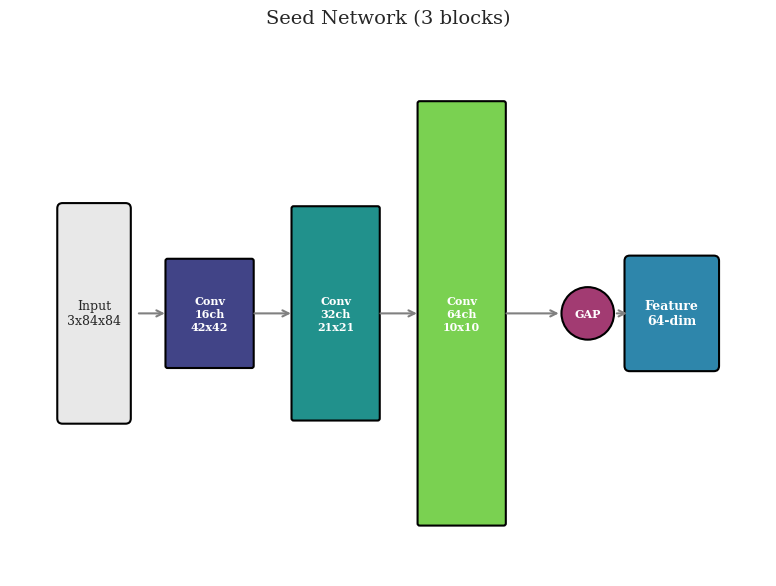

In [3]:
def draw_architecture_diagram(
    channel_sizes: list,
    title: str = "Network Architecture"
) -> plt.Figure:
    fig, ax = plt.subplots(figsize=(14, 6))
    num_blocks = len(channel_sizes)
    block_width = 0.8
    spacing = 1.2
    max_height = 4.0
    max_channels = max(channel_sizes)
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, num_blocks))
    ax.add_patch(mpatches.FancyBboxPatch(
        (-1, 1), 0.6, 2, boxstyle="round,pad=0.05",
        facecolor="#E8E8E8", edgecolor="black", linewidth=1.5
    ))
    ax.text(-0.7, 2, "Input\n3x84x84", ha="center", va="center", fontsize=9)
    spatial_size = 84
    for idx, channels in enumerate(channel_sizes):
        x_pos = idx * spacing
        height = (channels / max_channels) * max_height
        y_pos = (max_height - height) / 2
        rect = mpatches.FancyBboxPatch(
            (x_pos, y_pos), block_width, height,
            boxstyle="round,pad=0.02",
            facecolor=colors[idx], edgecolor="black", linewidth=1.5
        )
        ax.add_patch(rect)
        spatial_size = spatial_size // 2
        ax.text(
            x_pos + block_width / 2, y_pos + height / 2,
            f"Conv\n{channels}ch\n{spatial_size}x{spatial_size}",
            ha="center", va="center", fontsize=8, color="white", weight="bold"
        )
        if idx > 0:
            prev_x = (idx - 1) * spacing + block_width
            ax.annotate(
                "", xy=(x_pos, max_height / 2),
                xytext=(prev_x, max_height / 2),
                arrowprops=dict(arrowstyle="->", color="gray", lw=1.5)
            )
    ax.annotate(
        "", xy=(0, max_height / 2),
        xytext=(-0.3, 2),
        arrowprops=dict(arrowstyle="->", color="gray", lw=1.5)
    )
    final_x = (num_blocks - 1) * spacing + block_width + 0.5
    ax.add_patch(mpatches.Circle(
        (final_x + 0.3, max_height / 2), 0.25,
        facecolor="#A23B72", edgecolor="black", linewidth=1.5
    ))
    ax.text(
        final_x + 0.3, max_height / 2, "GAP",
        ha="center", va="center", fontsize=8, color="white", weight="bold"
    )
    ax.annotate(
        "", xy=(final_x + 0.05, max_height / 2),
        xytext=((num_blocks - 1) * spacing + block_width, max_height / 2),
        arrowprops=dict(arrowstyle="->", color="gray", lw=1.5)
    )
    ax.add_patch(mpatches.FancyBboxPatch(
        (final_x + 0.7, 1.5), 0.8, 1,
        boxstyle="round,pad=0.05",
        facecolor="#2E86AB", edgecolor="black", linewidth=1.5
    ))
    ax.text(
        final_x + 1.1, 2, f"Feature\n{channel_sizes[-1]}-dim",
        ha="center", va="center", fontsize=9, color="white", weight="bold"
    )
    ax.annotate(
        "", xy=(final_x + 0.7, 2),
        xytext=(final_x + 0.55, max_height / 2),
        arrowprops=dict(arrowstyle="->", color="gray", lw=1.5)
    )
    ax.set_xlim(-1.5, final_x + 2)
    ax.set_ylim(-0.5, max_height + 0.5)
    ax.set_aspect("equal")
    ax.axis("off")
    ax.set_title(title, fontsize=14, pad=20)
    plt.tight_layout()
    return fig


seed_config = SeedNetworkConfig()
growth_config = GrowthConfig()
model = EvolvableCNN(seed_config, growth_config)

fig = draw_architecture_diagram(model.channel_sizes, "Seed Network (3 blocks)")
plt.show()

In [4]:
def simulate_evolution(
    model: EvolvableCNN,
    num_grow_steps: int = 5,
    num_widen_steps: int = 2,
) -> list:
    evolution_history = [{
        "step": 0,
        "mutation": "initial",
        "num_blocks": model.num_blocks,
        "channel_sizes": model.channel_sizes.copy(),
        "params": model.count_parameters(),
    }]
    step = 1
    for _ in range(num_grow_steps):
        success = model.grow()
        if success:
            evolution_history.append({
                "step": step,
                "mutation": "grow",
                "num_blocks": model.num_blocks,
                "channel_sizes": model.channel_sizes.copy(),
                "params": model.count_parameters(),
            })
            step += 1
    for i in range(num_widen_steps):
        success = model.widen(block_idx=i)
        if success:
            evolution_history.append({
                "step": step,
                "mutation": f"widen[{i}]",
                "num_blocks": model.num_blocks,
                "channel_sizes": model.channel_sizes.copy(),
                "params": model.count_parameters(),
            })
            step += 1
    return evolution_history


model = EvolvableCNN(seed_config, growth_config)
evolution_history = simulate_evolution(model, num_grow_steps=5, num_widen_steps=2)

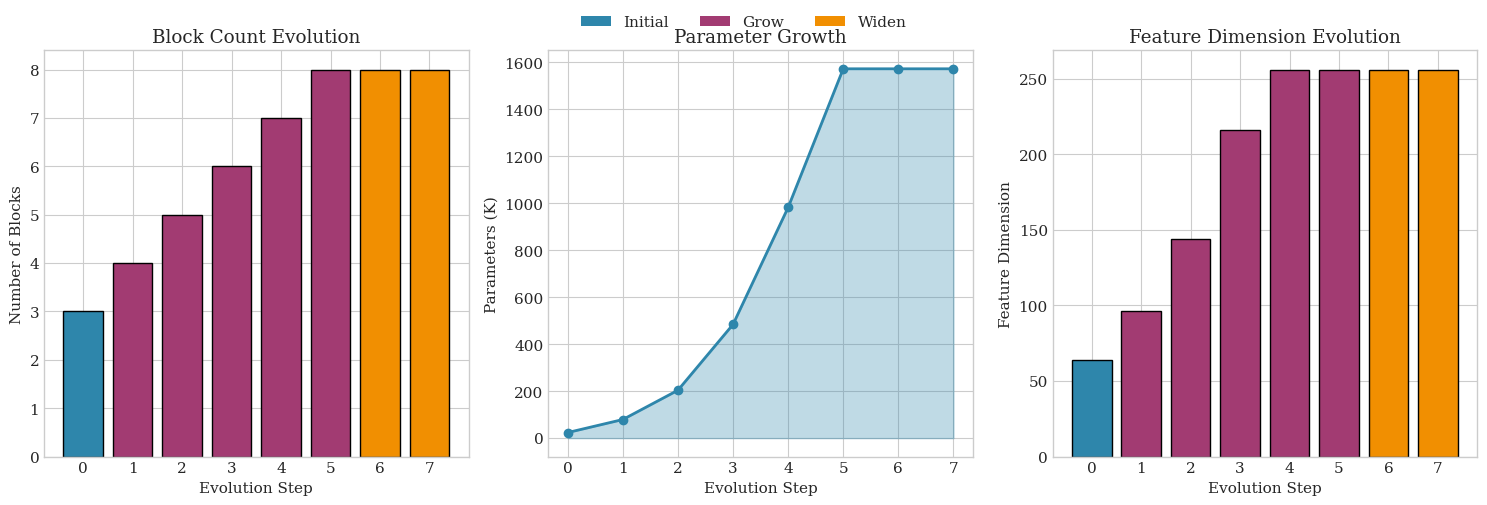

In [5]:
def plot_evolution_trajectory(history: list) -> plt.Figure:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    steps = [h["step"] for h in history]
    blocks = [h["num_blocks"] for h in history]
    params = [h["params"] / 1000 for h in history]
    feature_dims = [h["channel_sizes"][-1] for h in history]
    mutations = [h["mutation"] for h in history]
    colors = []
    for m in mutations:
        if m == "initial":
            colors.append("#2E86AB")
        elif m == "grow":
            colors.append("#A23B72")
        else:
            colors.append("#F18F01")
    axes[0].bar(steps, blocks, color=colors, edgecolor="black", linewidth=1)
    axes[0].set_xlabel("Evolution Step")
    axes[0].set_ylabel("Number of Blocks")
    axes[0].set_title("Block Count Evolution")
    axes[1].plot(steps, params, marker="o", linewidth=2, color="#2E86AB")
    axes[1].fill_between(steps, params, alpha=0.3, color="#2E86AB")
    axes[1].set_xlabel("Evolution Step")
    axes[1].set_ylabel("Parameters (K)")
    axes[1].set_title("Parameter Growth")
    axes[2].bar(steps, feature_dims, color=colors, edgecolor="black", linewidth=1)
    axes[2].set_xlabel("Evolution Step")
    axes[2].set_ylabel("Feature Dimension")
    axes[2].set_title("Feature Dimension Evolution")
    legend_elements = [
        mpatches.Patch(facecolor="#2E86AB", label="Initial"),
        mpatches.Patch(facecolor="#A23B72", label="Grow"),
        mpatches.Patch(facecolor="#F18F01", label="Widen"),
    ]
    fig.legend(handles=legend_elements, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.02))
    plt.tight_layout()
    return fig


fig = plot_evolution_trajectory(evolution_history)
plt.show()

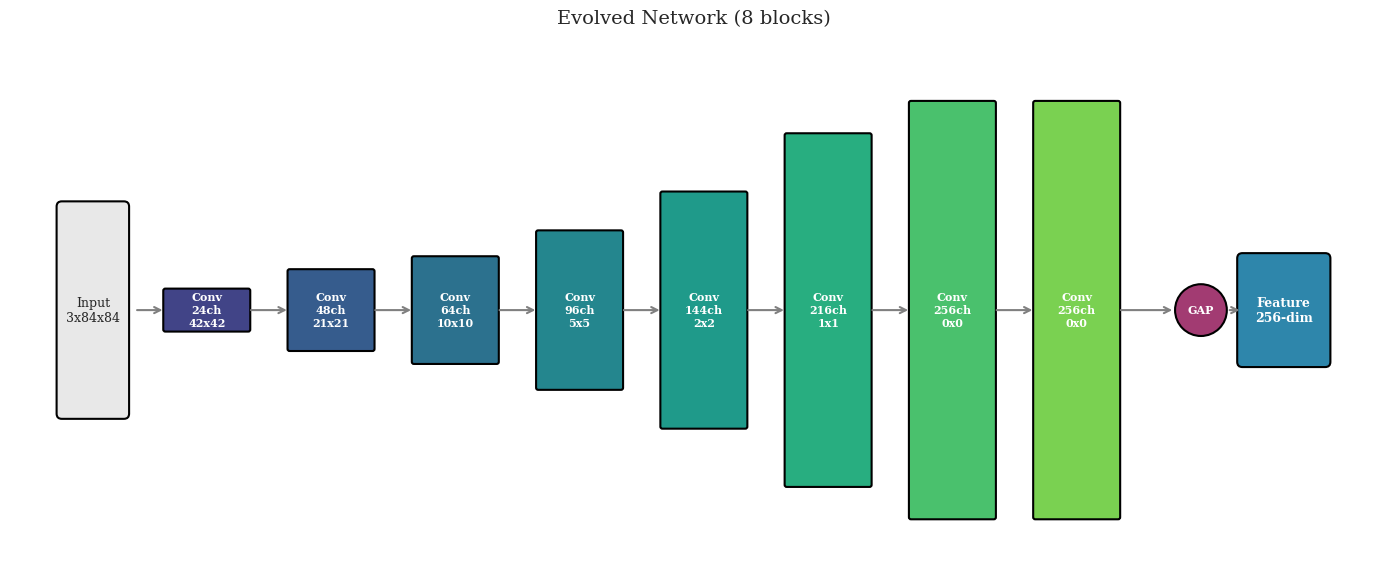

In [6]:
fig = draw_architecture_diagram(
    evolution_history[-1]["channel_sizes"],
    f"Evolved Network ({evolution_history[-1]['num_blocks']} blocks)"
)
plt.show()

In [7]:
def print_evolution_summary(history: list) -> None:
    print("=" * 70)
    print("EVOLUTION SUMMARY")
    print("=" * 70)
    print(f"{'Step':<8} {'Mutation':<15} {'Blocks':>8} {'Params':>12} {'Feature':>10}")
    print("-" * 70)
    for h in history:
        params_str = f"{h['params']:,}"
        print(
            f"{h['step']:<8} {h['mutation']:<15} {h['num_blocks']:>8} "
            f"{params_str:>12} {h['channel_sizes'][-1]:>10}"
        )
    print("-" * 70)
    initial = history[0]
    final = history[-1]
    param_growth = final["params"] / initial["params"]
    block_growth = final["num_blocks"] / initial["num_blocks"]
    print(f"Parameter Growth: {param_growth:.2f}x")
    print(f"Block Growth: {block_growth:.2f}x")
    print(f"Feature Dim Growth: {final['channel_sizes'][-1] / initial['channel_sizes'][-1]:.2f}x")
    print("=" * 70)


print_evolution_summary(evolution_history)

EVOLUTION SUMMARY
Step     Mutation          Blocks       Params    Feature
----------------------------------------------------------------------
0        initial                3       23,696         64
1        grow                   4       79,184         96
2        grow                   5      203,888        144
3        grow                   6      484,256        216
4        grow                   7      982,432        256
5        grow                   8    1,572,768        256
6        widen[0]               8    1,572,768        256
7        widen[1]               8    1,572,768        256
----------------------------------------------------------------------
Parameter Growth: 66.37x
Block Growth: 2.67x
Feature Dim Growth: 4.00x
